# Import Libraries

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import pandas as pd
from scipy.stats import shapiro, anderson, normaltest
from scipy.stats import bartlett
import scikit_posthocs as sp
from scipy.stats import kruskal
from scipy.stats import levene

# Scenario 
Сеть ресторанов быстрого питания планирует добавить новое блюдо в свое меню. Однако они все еще не определились с выбором между тремя возможными маркетинговыми кампаниями по продвижению нового продукта. Чтобы определить, какая рекламная акция окажет наибольшее влияние на продажи, новое блюдо предлагается в точках на нескольких случайно выбранных рынках. В каждом месте используется своя рекламная акция, и еженедельные продажи нового товара регистрируются в течение первых четырех недель.

# Columns
* MarketID: уникальный идентификатор для рынка
* MarketSize: размер рыночной площади по объемам продаж
* LocationID: уникальный идентификатор местоположения магазина
* AgeOfStore: возраст магазина в годах 
* Promotion: одна из трех протестированных рекламных акций
* week: одна из четырех недель, когда проводились рекламные акции
* SalesInThousands: сумма продаж для определенного идентификатора местоположения, рекламной акции и недели

# Describing Data

In [4]:
data = pd.read_csv('/kaggle/input/fast-food-marketing-campaign-ab-test/WA_Marketing-Campaign.csv')
data

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
...,...,...,...,...,...,...,...
543,10,Large,919,2,1,4,64.34
544,10,Large,920,14,2,1,50.20
545,10,Large,920,14,2,2,45.75
546,10,Large,920,14,2,3,44.29


In [5]:
def check_df(dataframe, head = 5):
    print("_______________ Shape _______________")
    print(dataframe.shape)
    print("_______________ Types _______________")
    print(dataframe.dtypes)
    print("_______________ Head _______________")
    print(dataframe.head(head))
    print("_______________ Tail _______________")
    print(dataframe.tail(head))
    print("_______________ NA _______________")
    print(dataframe.isnull().sum())
    print("_______________ Quantiles _______________")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(data)

_______________ Shape _______________
(548, 7)
_______________ Types _______________
MarketID              int64
MarketSize           object
LocationID            int64
AgeOfStore            int64
Promotion             int64
week                  int64
SalesInThousands    float64
dtype: object
_______________ Head _______________
   MarketID MarketSize  LocationID  AgeOfStore  Promotion  week  \
0         1     Medium           1           4          3     1   
1         1     Medium           1           4          3     2   
2         1     Medium           1           4          3     3   
3         1     Medium           1           4          3     4   
4         1     Medium           2           5          2     1   

   SalesInThousands  
0             33.73  
1             35.67  
2             29.03  
3             39.25  
4             27.81  
_______________ Tail _______________
     MarketID MarketSize  LocationID  AgeOfStore  Promotion  week  \
543        10      Large   

In [6]:
data.groupby(['MarketSize','Promotion']).agg({'SalesInThousands':["count", "mean", "sum"]})

SalesInThousands                    
                                count       mean      sum
MarketSize Promotion                                     
Large      1                       56  75.235893  4213.21
           2                       64  60.322031  3860.61
           3                       48  77.203958  3705.79
Medium     1                       96  47.672604  4576.57
           2                      108  39.114352  4224.35
           3                      116  45.468879  5274.39
Small      1                       20  60.162500  1203.25
           2                       16  50.810625   812.97
           3                       24  59.514167  1428.34

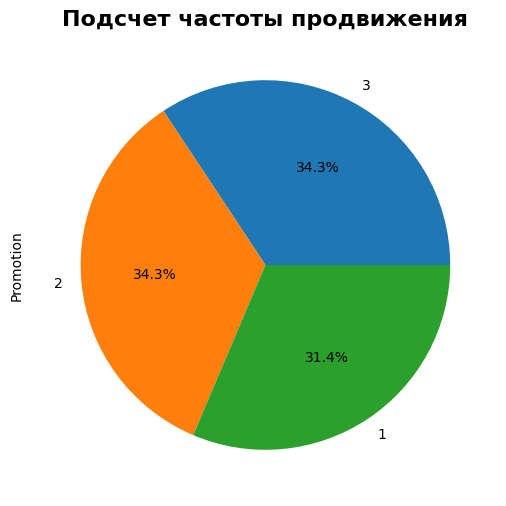

In [10]:
# Pie chart of Promotion variable
plt.figure(figsize=(10,6))
data['Promotion'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Подсчет частоты продвижения", fontsize=16, fontweight='bold')

plt.show()

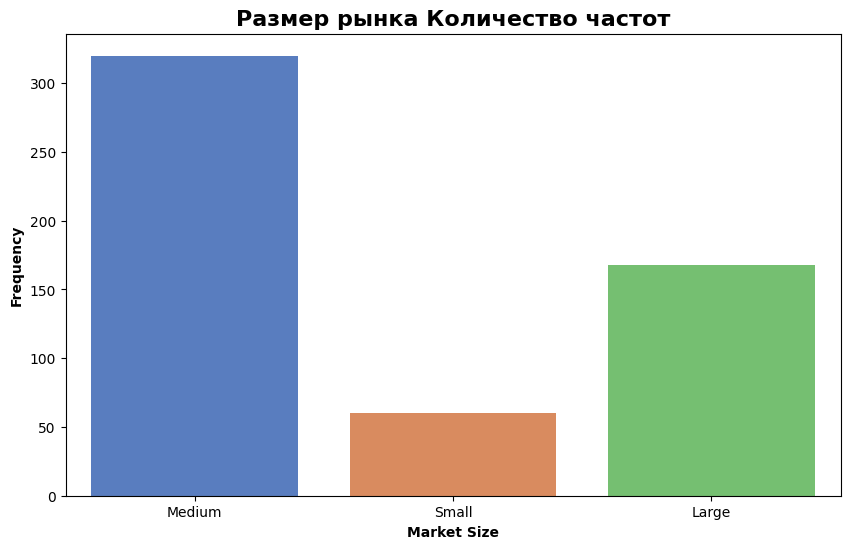

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(x='MarketSize', data=data, palette='muted')
plt.title("Размер рынка Количество частот", fontsize=16, fontweight='bold')
plt.xlabel("Market Size", fontweight='bold')
plt.ylabel("Frequency", fontweight='bold')
plt.show()

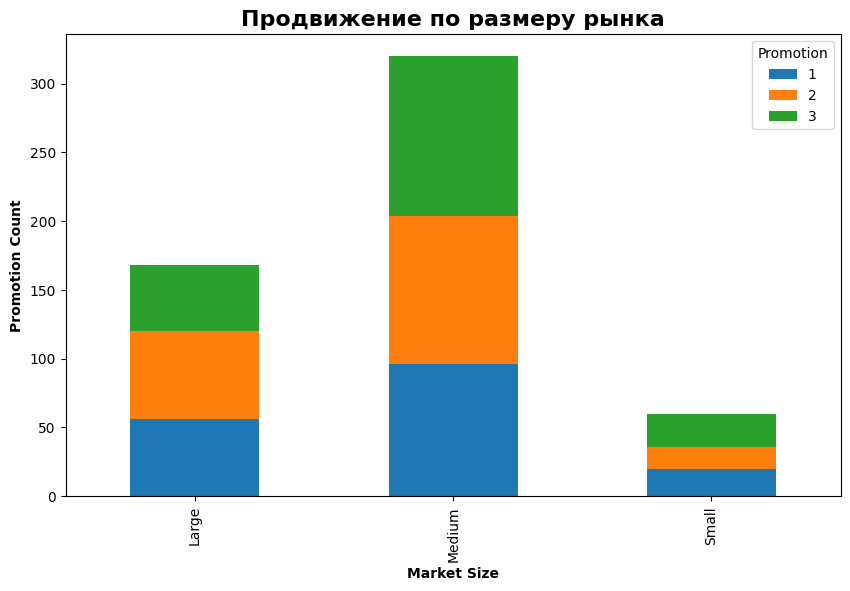

In [12]:
promo_by_market = data.groupby(['MarketSize', 'Promotion'])['MarketSize'].count().unstack('Promotion')
promo_by_market.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title("Продвижение по размеру рынка", fontweight='bold', fontsize=16)
plt.xlabel("Market Size", fontweight='bold')
plt.ylabel("Promotion Count", fontweight='bold')

plt.show()


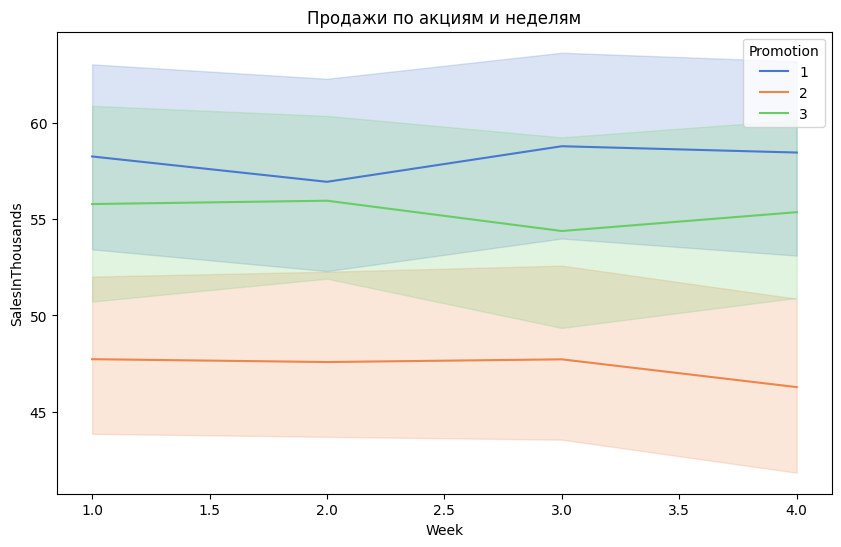

In [13]:
plt.figure(figsize=(10,6))
sns.lineplot(x='week', y='SalesInThousands', hue='Promotion', data= data, palette='muted')
plt.title("Продажи по акциям и неделям")
plt.xlabel("Week")
plt.ylabel("SalesInThousands")
plt.show()

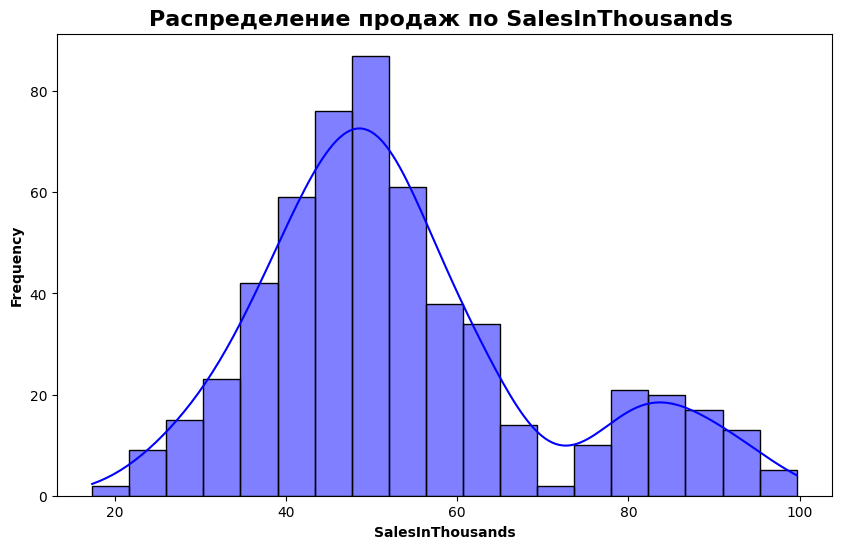

In [15]:
plt.figure(figsize=(10,6))
sns.histplot(data['SalesInThousands'], kde=True, color='b')
plt.title("Распределение продаж по SalesInThousands ", fontsize=16, fontweight='bold')
plt.xlabel("SalesInThousands", fontweight='bold')
plt.ylabel("Frequency", fontweight='bold')
plt.show()

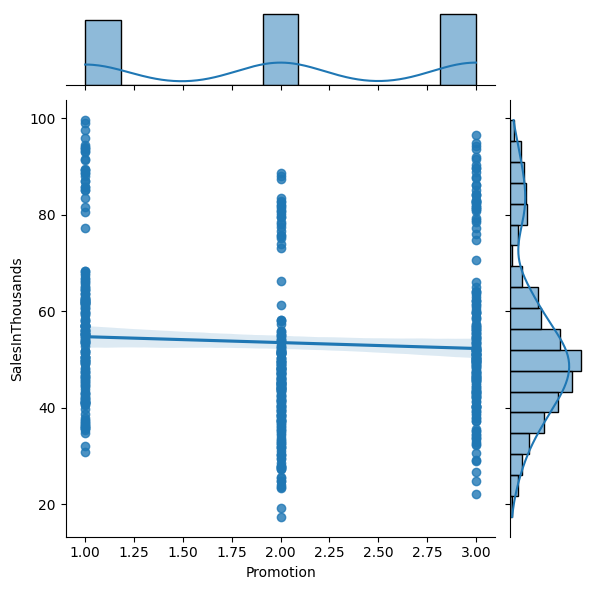

In [16]:
sns.jointplot(x = "Promotion", y = "SalesInThousands", data = data, kind = "reg")

# A/B Test

Чтобы привести A/B-тест к заданной связи с разграничивающими действиями, в данном случае мы решили использовать однофакторный анализ данных (ANOVA).

Дисперсионный анализ - это статистический метод, предназначенный для сравнения средних значений между тремя или более группами. В нашем случае у нас есть три разных склада (группы A, B и C), и мы хотим определить, существуют ли статистически значимые различия в среднем объеме продаж между этими группами.

Почему мы выбрали ANOVA для этого теста:

Несколько групп: У нас есть три группы, и ANOVA позволяет нам равномерно распределить средние значения между несколькими группами. Это позволяет нам выявить различия между группами A, B и C и определить, есть ли статистически значимые различия.

Однофакторный дизайн: У нас есть только один фактор - запасы, которые мы сравниваем. НОВЫЙ подход к анализу данных с помощью единого редактора.

Непараметрические показатели: Если предположение ANOVA не выполняется (например, нормальность распределения не удовлетворена), непараметрические показатели изменяются

Что вам нужно для проведения ANOVA:
1. Нормальность распределения:

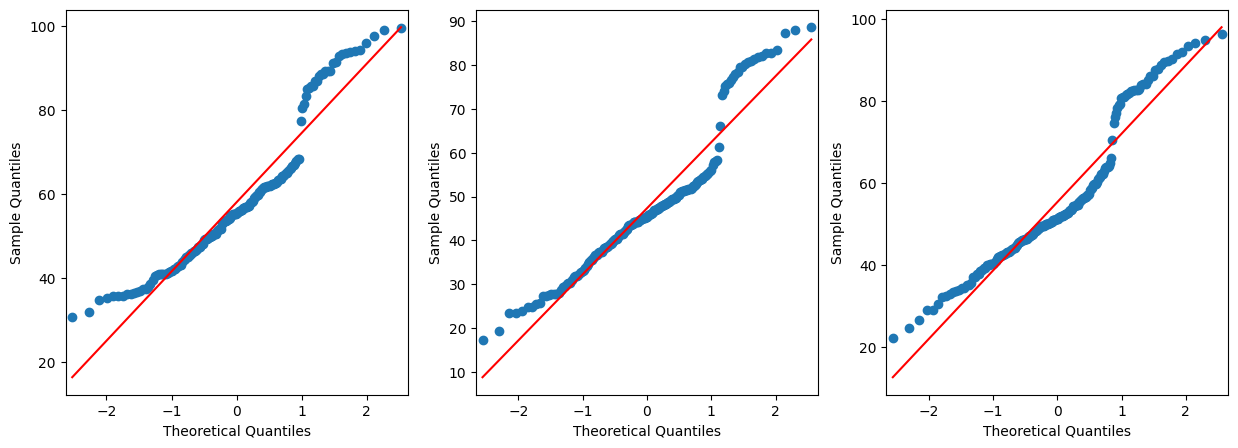

In [17]:
fig, axs = plt.subplots(1,3, figsize = (15,5))

qqplot(np.array(data.loc[(data['Promotion'] == 1), 'SalesInThousands']), ax = axs[0], line="s")
qqplot(np.array(data.loc[(data['Promotion'] == 2), 'SalesInThousands']), ax = axs[1], line="s")
qqplot(np.array(data.loc[(data['Promotion'] == 3), 'SalesInThousands']), ax = axs[2], line="s")


plt.show()

In [18]:
promotion_1_data = data[data['Promotion'] == 1]['SalesInThousands']

# Тест Шапиро-Уилка
stat_shapiro, p_shapiro = shapiro(promotion_1_data)
print("Shapiro-Wilk test:")
print("Statistic =", stat_shapiro)
print("p-value =", p_shapiro)
if p_shapiro < 0.05:
    print("The distribution is not normal")
else:
    print("The distribution is normal")

# Тест Андерсона-Дарлинга
result_anderson = anderson(promotion_1_data)
print("\nAnderson-Darling test:")
print("Statistic =", result_anderson.statistic)
print("Critical values =", result_anderson.critical_values)
print("Significance levels =", result_anderson.significance_level)
if result_anderson.statistic > result_anderson.critical_values[-1]:
    print("The distribution is not normal")
else:
    print("The distribution is normal")

# Тест на нормальность Д'Агостино и Пирсона
stat_normal, p_normal = normaltest(promotion_1_data)
print("\nD'Agostino and Pearson's test for normality:")
print("Statistic =", stat_normal)
print("p-value =", p_normal)
if p_normal < 0.05:
    print("The distribution is not normal")
else:
    print("The distribution is normal")

Shapiro-Wilk test:
Statistic = 0.9152998328208923
p-value = 1.977244323825289e-08
The distribution is not normal

Anderson-Darling test:
Statistic = 4.811285489370505
Critical values = [0.563 0.642 0.77  0.898 1.068]
Significance levels = [15.  10.   5.   2.5  1. ]
The distribution is not normal

D'Agostino and Pearson's test for normality:
Statistic = 17.938630886905376
p-value = 0.0001272552757774151
The distribution is not normal


In [19]:
promotion_1_data = data[data['Promotion'] == 2]['SalesInThousands']

# Тест Шапиро-Уилка
stat_shapiro, p_shapiro = shapiro(promotion_1_data)
print("Shapiro-Wilk test:")
print("Statistic =", stat_shapiro)
print("p-value =", p_shapiro)
if p_shapiro < 0.05:
    print("The distribution is not normal")
else:
    print("The distribution is normal")

# Тест Андерсона-Дарлинга
result_anderson = anderson(promotion_1_data)
print("\nAnderson-Darling test:")
print("Statistic =", result_anderson.statistic)
print("Critical values =", result_anderson.critical_values)
print("Significance levels =", result_anderson.significance_level)
if result_anderson.statistic > result_anderson.critical_values[-1]:
    print("The distribution is not normal")
else:
    print("The distribution is normal")

# Тест на нормальность Д'Агостино и Пирсона
stat_normal, p_normal = normaltest(promotion_1_data)
print("\nD'Agostino and Pearson's test for normality:")
print("Statistic =", stat_normal)
print("p-value =", p_normal)
if p_normal < 0.05:
    print("The distribution is not normal")
else:
    print("The distribution is normal")


Shapiro-Wilk test:
Statistic = 0.9145088791847229
p-value = 5.456262108793908e-09
The distribution is not normal

Anderson-Darling test:
Statistic = 5.560416002264333
Critical values = [0.564 0.643 0.771 0.899 1.07 ]
Significance levels = [15.  10.   5.   2.5  1. ]
The distribution is not normal

D'Agostino and Pearson's test for normality:
Statistic = 24.69140693475036
p-value = 4.348396213594891e-06
The distribution is not normal


In [20]:
promotion_1_data = data[data['Promotion'] == 3]['SalesInThousands']

# Тест Шапиро-Уилка
stat_shapiro, p_shapiro = shapiro(promotion_1_data)
print("Shapiro-Wilk test:")
print("Statistic =", stat_shapiro)
print("p-value =", p_shapiro)
if p_shapiro < 0.05:
    print("The distribution is not normal")
else:
    print("The distribution is normal")

# Тест Андерсона-Дарлинга
result_anderson = anderson(promotion_1_data)
print("\nAnderson-Darling test:")
print("Statistic =", result_anderson.statistic)
print("Critical values =", result_anderson.critical_values)
print("Significance levels =", result_anderson.significance_level)
if result_anderson.statistic > result_anderson.critical_values[-1]:
    print("The distribution is not normal")
else:
    print("The distribution is normal")

# Тест на нормальность Д'Агостино и Пирсона
stat_normal, p_normal = normaltest(promotion_1_data)
print("\nD'Agostino and Pearson's test for normality:")
print("Statistic =", stat_normal)
print("p-value =", p_normal)
if p_normal < 0.05:
    print("The distribution is not normal")
else:
    print("The distribution is normal")

Shapiro-Wilk test:
Statistic = 0.9207685589790344
p-value = 1.499518376135711e-08
The distribution is not normal

Anderson-Darling test:
Statistic = 6.11407995911344
Critical values = [0.564 0.643 0.771 0.899 1.07 ]
Significance levels = [15.  10.   5.   2.5  1. ]
The distribution is not normal

D'Agostino and Pearson's test for normality:
Statistic = 16.08681258836211
p-value = 0.0003212129387460442
The distribution is not normal


К сожалению, все p-значения ниже 0,05, поэтому предположение о нормальности не выполняется.

2. Однородность дисперсии:

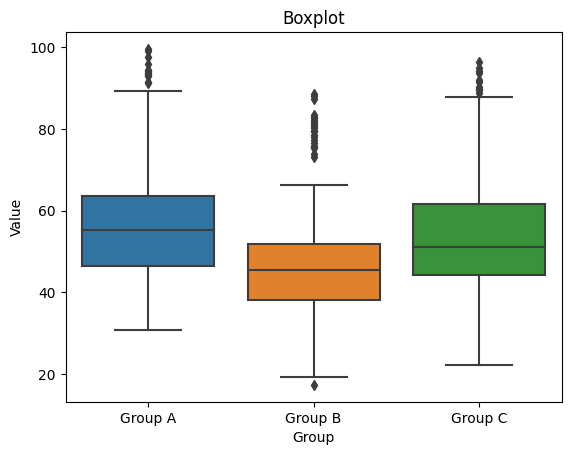

In [21]:
group_A = data.loc[data['Promotion'] == 1, 'SalesInThousands']
group_B = data.loc[data['Promotion'] == 2, 'SalesInThousands']
group_C = data.loc[data['Promotion'] == 3, 'SalesInThousands']

data = pd.DataFrame({'Group A': group_A, 'Group B': group_B, 'Group C': group_C})

sns.boxplot(data=data)

plt.xlabel('Group')
plt.ylabel('Value')
plt.title('Boxplot')
plt.show()


In [22]:
statistic, p_value = levene(group_A, group_B, group_C)

print("Levene's test:")
print("Statistic =", statistic)
print("p-value =", p_value)
if p_value < 0.05:
    print("Homoscedasticity is rejected")
else:
    print("Homoscedasticity is not rejected")

Levene's test:
Statistic = 1.2696787527507418
p-value = 0.2817514565692118
Homoscedasticity is not rejected


Результаты теста Левина указывают на отсутствие статистически значимых различий в дисперсии между группами. Мы не отвергаем нулевую гипотезу гомоскедастичности, но поскольку условие нормальности распределения не выполняется, то односторонний ANOVA-анализ не является наиболее подходящим вариантом тестирования. Мы должны использовать односторонний ANOVA Крускала-Уоллиса.

In [23]:
statistic, p_value = kruskal(group_A, group_B, group_C)

print("Kruskal-Wallis test:")
print("Statistic =", statistic)
print("p-value =", p_value)

if p_value < 0.05:
    print("There are significant differences between groups.")
else:
    print("There are no significant differences between groups.")


Kruskal-Wallis test:
Statistic = 53.29475169322799
p-value = 2.6741866266697816e-12
There are significant differences between groups.


P-значение критерия Крискала-Уоллиса намного ниже 0,05, поэтому нулевая гипотеза отвергается. Это означает, что рекламная акция оказывает влияние на продажи.

# Post-Hoc Dunn

В тесте Данна гипотезой являются:

Нулевая гипотеза (Ho): Средние значения двух групп (повышение по службе) равны. Альтернативная гипотеза (Ha): Средние значения двух групп (повышение по службе) не равны.

In [32]:
if p_value < 0.05:
    posthoc_dunn = sp.posthoc_dunn([group_A, group_B, group_C])
    print("Post-Hoc Dunn's test:")
    print(posthoc_dunn)
    

Post-Hoc Dunn's test:
              1             2             3
1  1.000000e+00  2.153947e-12  4.862200e-02
2  2.153947e-12  1.000000e+00  2.361023e-07
3  4.862200e-02  2.361023e-07  1.000000e+00


Результатом теста является p-значение критерия Данна для каждой пары рекламных акций. Следовательно, если p-значение больше 0,05 (уровень значимости), принимается нулевая гипотеза, в противном случае она отклоняется.

* Акция 1 против акции 2: нулевая гипотеза отклонена.
* Акция 1 против акции 3: нулевая гипотеза принята.
* Акция 2 против акции 3: нулевая гипотеза отклонена.

Мы можем ожидать более высоких продаж при проведении акций 1 и 3, чем при проведении акции 2.